In [2]:
import pandas as pd
import numpy as np
import nflreadpy as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
chap_3_file = "./data/pbp_py_chap_3_book.csv"

# load data
if os.path.isfile(chap_3_file):
    pbp_py = pd.read_csv(chap_3_file, low_memory=False)
else:
    seasons = list(range(2016, 2022 + 1))

    pbp_pl = nfl.load_pbp(seasons=seasons)   # Polars DataFrame
    pbp_py = pbp_pl.to_pandas()              # convert to pandas

    pbp_py.to_csv(chap_3_file, index=False)

In [4]:
pbp_py = pbp_py.copy()  # de-fragment

In [5]:
## filter run data and replace missing values
pbp_py_run = pbp_py.query('play_type == "run" & rusher_id.notnull()').reset_index()
pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

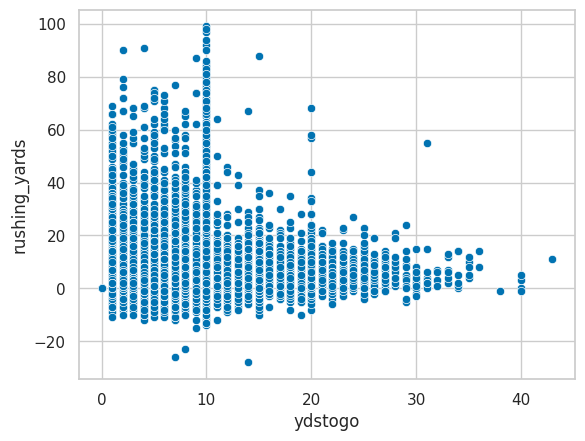

In [6]:
## plot raw data prior to building model
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards")
plt.show()

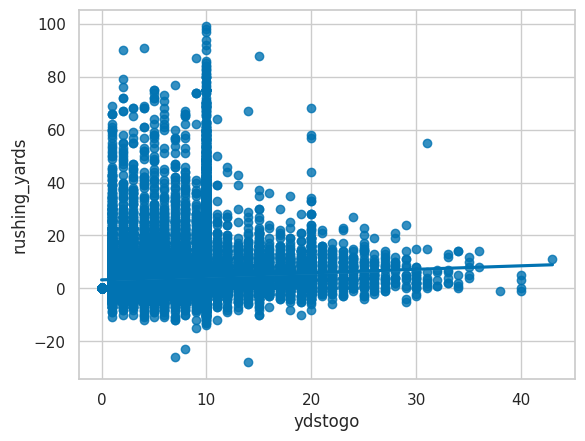

In [7]:
## add linear trend line
sns.regplot(data=pbp_py_run, x="ydstogo", y="rushing_yards")
plt.show()

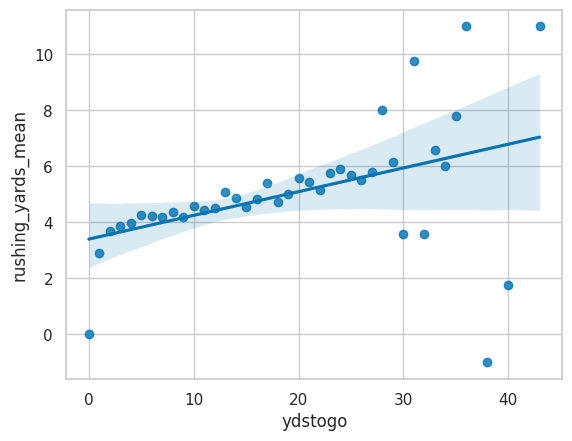

In [8]:
## bin and plot data
pbp_py_run_ave = pbp_py_run.groupby(["ydstogo"]).agg({"rushing_yards": ["mean"]})
pbp_py_run_ave.columns = list(map("_".join, pbp_py_run_ave.columns))
pbp_py_run_ave.reset_index(inplace=True)
sns.regplot(data=pbp_py_run_ave, x="ydstogo", y="rushing_yards_mean")
plt.show()

In [9]:
## build and fit linear regression
yard_to_go_py = smf.ols(formula="rushing_yards ~ 1 + ydstogo", data=pbp_py_run)
print(yard_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     623.3
Date:                Wed, 28 Jan 2026   Prob (F-statistic):          4.09e-137
Time:                        19:38:24   Log-Likelihood:            -3.0103e+05
No. Observations:               92413   AIC:                         6.021e+05
Df Residuals:                   92411   BIC:                         6.021e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2187      0.047     68.136      0.0

In [10]:
## save residuals as RYOE
pbp_py_run["ryoe"] = yard_to_go_py.fit().resid

In [11]:
## query, format, and print RYOE results
ryoe_py = pbp_py_run.groupby(["season", "rusher_id", "rusher"]).agg(
    {"ryoe": ["count", "sum", "mean"], "rushing_yards": "mean"}
)

ryoe_py.columns = list(map("_".join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

ryoe_py = ryoe_py.rename(
    columns={
        "ryoe_count": "n",
        "ryoe_sum": "ryoe_total",
        "ryoe_mean": "ryoe_per",
        "rushing_yards_mean": "yards_per_carry",
    }
).query("n > 50")

print(ryoe_py.sort_values("ryoe_total", ascending=False))

      season   rusher_id     rusher    n  ryoe_total  ryoe_per  \
1988    2021  00-0036223   J.Taylor  332  417.609456  1.257860   
1439    2020  00-0032764    D.Henry  397  362.907643  0.914125   
1257    2019  00-0034796  L.Jackson  135  353.695489  2.619967   
1143    2019  00-0032764    D.Henry  387  324.057286  0.837357   
1473    2020  00-0033293    A.Jones  222  288.433136  1.299248   
...      ...         ...        ...  ...         ...       ...   
419     2017  00-0029613   D.Martin  139 -198.410654 -1.427415   
122     2016  00-0029613   D.Martin  144 -199.105621 -1.382678   
675     2018  00-0027325   L.Blount  155 -247.473959 -1.596606   
1058    2019  00-0030496     L.Bell  245 -286.904354 -1.171038   
267     2016  00-0032241   T.Gurley  278 -319.703394 -1.150012   

      yards_per_carry  
1988         5.454819  
1439         5.206549  
1257         6.800000  
1143         5.131783  
1473         5.540541  
...               ...  
419          2.920863  
122          2.

In [12]:
## Sorting by ryoe_per
print(ryoe_py.sort_values("ryoe_per", ascending=False))

      season   rusher_id        rusher    n  ryoe_total  ryoe_per  \
2234    2022  00-0034796     L.Jackson   73  275.860598  3.778912   
1257    2019  00-0034796     L.Jackson  135  353.695489  2.619967   
1285    2019  00-0035228      K.Murray   56  121.718709  2.173548   
1559    2020  00-0034796     L.Jackson  121  249.516928  2.062123   
1896    2021  00-0034750       R.Penny  119  229.287141  1.926783   
...      ...         ...           ...  ...         ...       ...   
1300    2019  00-0035342       P.Laird   61 -104.337460 -1.710450   
576     2017  00-0032940  D.Washington   57  -98.211931 -1.723016   
2021    2021  00-0036414       C.Akers   72 -139.502814 -1.937539   
67      2016  00-0027791      J.Starks   64 -129.938318 -2.030286   
1258    2019  00-0034799     K.Ballage   73 -190.308078 -2.606960   

      yards_per_carry  
2234         7.821918  
1257         6.800000  
1285         6.500000  
1559         6.264463  
1896         6.294118  
...               ...  
130

In [13]:
## RYOE stability
#  keep only columns needed
cols_keep = ["season", "rusher_id", "rusher", "ryoe_per", "yards_per_carry"]

In [14]:
# create current dataframe
ryoe_now_py = ryoe_py[cols_keep].copy()

In [15]:
# create last-year's dataframe
ryoe_last_py = ryoe_py[cols_keep].copy()

In [16]:
ryoe_last_py.rename(
    columns={"ryoe_per": "ryoe_per_last", "yards_per_carry": "yards_per_carry_last"},
    inplace=True,
)

In [18]:
# add 1 to season
ryoe_last_py["season"] += 1

In [19]:
# merge together
ryoe_lag_py = ryoe_now_py.merge(
    ryoe_last_py, how="inner", on=["rusher_id", "rusher", "season"]
)

In [20]:
## Look at correlation
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.000000,0.323719
yards_per_carry,0.323719,1.000000


In [21]:
## repeat with RYOE
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.349136
ryoe_per,0.349136,1.000000
